# **Assignment 4 - Model Extraction Attack & Adversarial Models**

## **Model Type:** Elastic Net, Monotonic Gradient Boosting Machines (MGBM), and Explainable Boosting Machines (EBM)

### **Group 3** - Bethel Mandizha, Miranda Montenegro, Rahul Saha, Zeyu Wang

-----

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu), Bethel Mandizha (bethel.mandizha@gwmail.gwu.edu), Miranda Montenegro (miranda.montenegrolopez@gwmail.gwu.edu), Rahul Saha (rahul.saha@gwmail.gwu.edu), & Zeyu Wang (zywang@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

DISCLAIMER: This notebook is not legal or compliance advice.

-----

### **Installation of Libraries to be Used**

In [10]:
#Only needs to be run once
#!pip install xgboost
#!pip install h2o
#!pip install graphviz

### **Importing Necessary Libraries**

In [12]:
#Data manipulation, plotting and metrics
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns  
import datetime   
import time  

#Model modules
import h2o                                                    
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  
from h2o.grid.grid_search import H2OGridSearch 
import xgboost as xgb  
import itertools 
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC 

#Setting numpy seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

#Setting number of threads
NTHREAD = 4

#h2o start and clearing of memory
h2o.init(max_mem_size='6G', nthreads=NTHREAD) 
h2o.remove_all()                              
h2o.no_progress() 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.241-b07, mixed mode)
  Starting server from C:\Users\moria\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\moria\AppData\Local\Temp\tmpngfz2d8z
  JVM stdout: C:\Users\moria\AppData\Local\Temp\tmpngfz2d8z\h2o_moria_started_from_python.out
  JVM stderr: C:\Users\moria\AppData\Local\Temp\tmpngfz2d8z\h2o_moria_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,10 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,"14 days, 2 hours and 25 minutes"
H2O_cluster_name:,H2O_from_python_moria_9evpzp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.325 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


#### Starting the Global Timer

In [14]:
tic = time.time()

### **Importing Applicable Data**

In [16]:
#Importing pre-processed training data and showing first 5 lines of the dataset
train_data = pd.read_csv('/Users/moria/Documents/Mirands/Resp ML/Assignment 1-2/hmda_train_preprocessed.csv')
train_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0
4,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,1,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0


In [17]:
#Importing pre-processed testing data and showing first 5 lines of the dataset
test_data = pd.read_csv('/Users/moria/Documents/Mirands/Resp ML/Assignment 1-2/hmda_test_preprocessed.csv')
test_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,1,0,-0.514393,-0.039293,0.244394,-0.215304,-0.474263,-0.017786,0.854601
1,1,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,0,-0.162614,0.126830,0.244394,-0.215304,-0.227585,-0.015014,-0.425131
2,2,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,...,1,1,0,-0.646310,0.552520,0.244394,-0.215304,-0.659271,-0.033378,-0.425131
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,3.662982,0.133614,0.244394,-0.215304,2.763389,0.025177,0.306144
4,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,-0.338504,0.552520,0.244394,-0.215304,-0.443428,-0.027834,0.306144


#### Assigning modeling roles for the data

In [19]:
#Setting target and features for the data
target = 'high_priced'
demographic_cols = ['black', 'asian','white', 'amind', 'hipac', 'hispanic', 'non_hispanic', 'male', 'female', 'agegte62', 'agelt62']
features = [col for col in train_data.columns if col not in demographic_cols + ['row_id',target]]

print('target =', target)
print('predictors =', features)

target = high_priced
predictors = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


### **Data Visualization**

#### Histograms

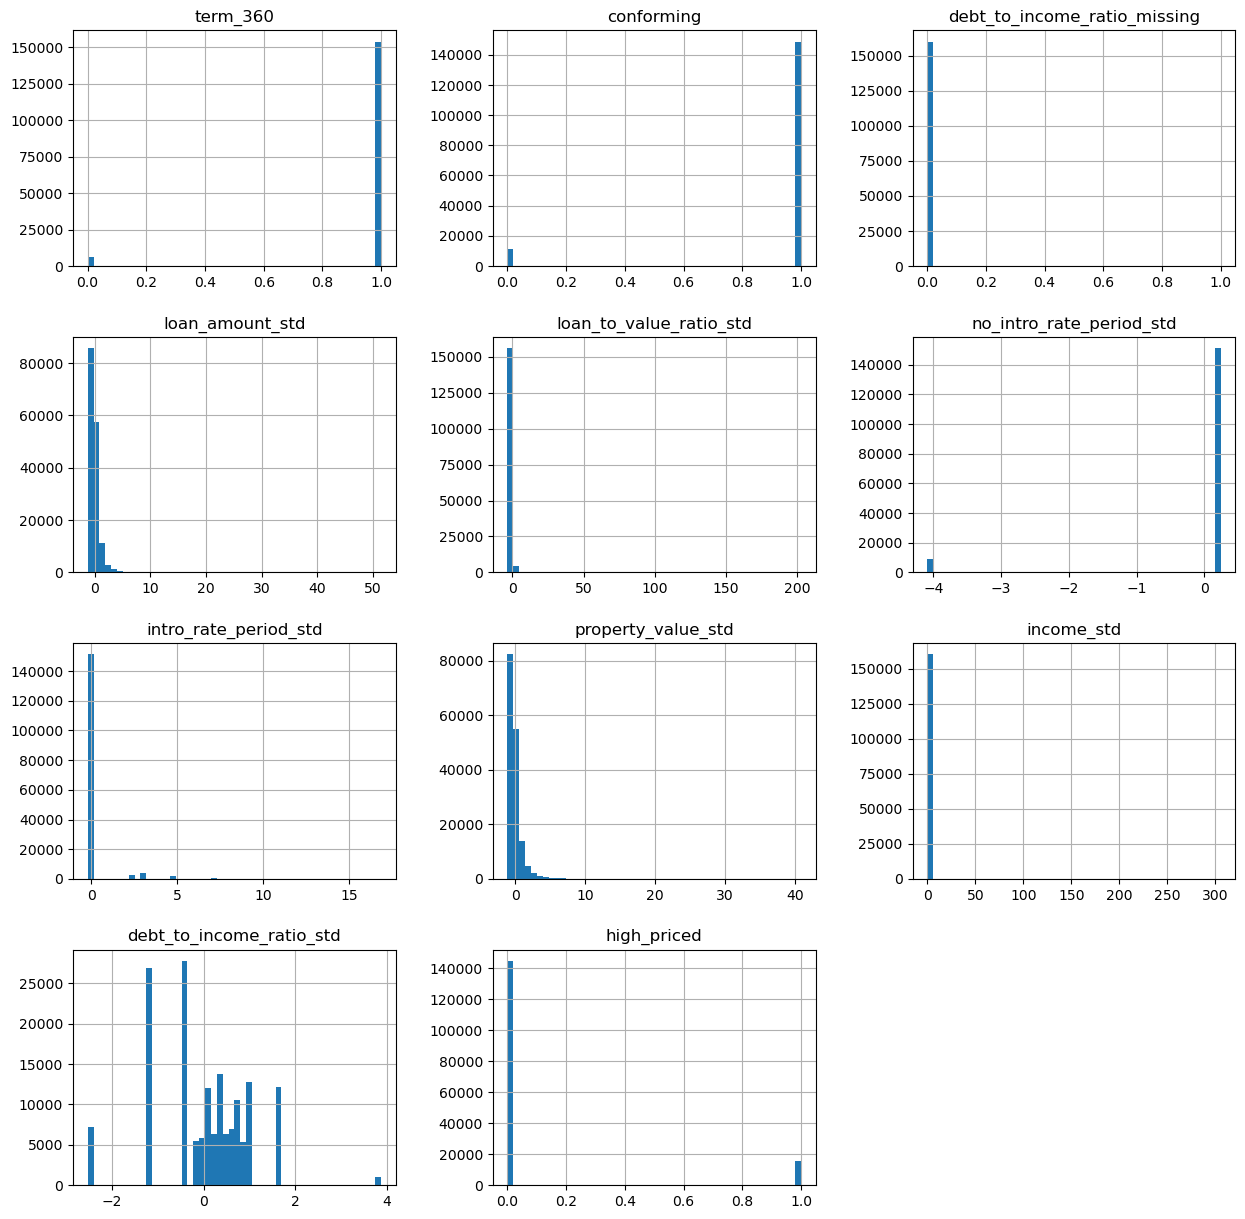

In [22]:
#Making histograms of the features to be analyzed and the target
_ = train_data[features + [target]].hist(bins=50, figsize=(15, 15))

#### Correlations

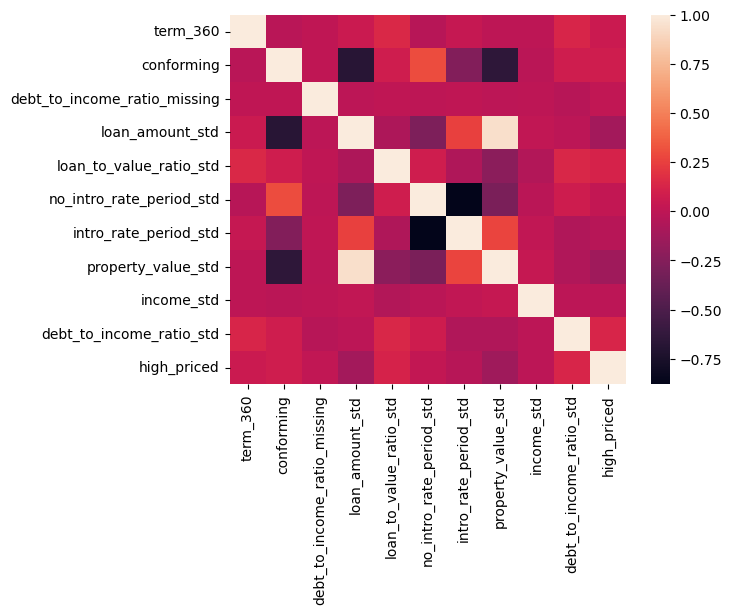

In [24]:
#Looking at the correlations between the features to be analyed and the target
corr = train_data[features + [target]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

### **Fitting the Data**

#### Start Timer

In [27]:
tic = time.time()

In [28]:
#Preserve exact reproducibility for this cell
np.random.seed(SEED) 

#Choosing a 70/30 train/test split 
split_ratio = 0.7

#Execute split
split = np.random.rand(len(train_data)) < split_ratio
train = train_data[split]
valid = train_data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

#Benchmark - Train data rows = 112253, columns = 23
#Benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### **Defining Utility Functions**

#### Additional Necessary Imports

In [31]:
from h2o.backend import H2OLocalServer                            
from h2o.estimators.random_forest import H2ORandomForestEstimator 
import subprocess                                                
from IPython.display import Image
from IPython.display import display

#### Utility Function That Trains a Cross-Validated Decision Tree

In [33]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    #Initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    #Train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    return tree

### **Retraining EBM for Assingment 4**

#### Retrain Most Accurate Model Above 0.8 AIR to Act as Blackbox Prediction API

In [36]:
#Params dict for remediated models - based on previous output in Assingment 3
rem_params = {'max_bins': 1024,
              'max_interaction_bins': 24,
              'interactions': 5,
              'outer_bags': 8,
              'inner_bags': 0,
              'learning_rate': 0.01,
              'validation_size': 0.05,
              'min_samples_leaf': 1,
              'max_leaves': 5,
              'early_stopping_rounds': 100,
              'n_jobs': NTHREAD,
              'random_state': SEED} 
 
rem_features = ['intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360',
               'property_value_std',
               'income_std',
               'debt_to_income_ratio_missing'] 

#Reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

#Retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_features], train[target])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_features], valid[target])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7815.


### **Model Extraction Attack**

#### Generate synthetic data for extraction attack

For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [40]:
#Best guess at feature distributions
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'debt_to_income_ratio_missing': {'p': 0.5, 'dist': 'binomial'},
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 #Rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) #Init empty frame

np.random.seed(SEED) #Same results each time cell is run

for j in list(schema_dict.keys()): #Loop through features

    #Simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'],
                                           size=N)

    #Simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'],
                                                                        size=N)

    #Simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

#### Visualize Simulated Data

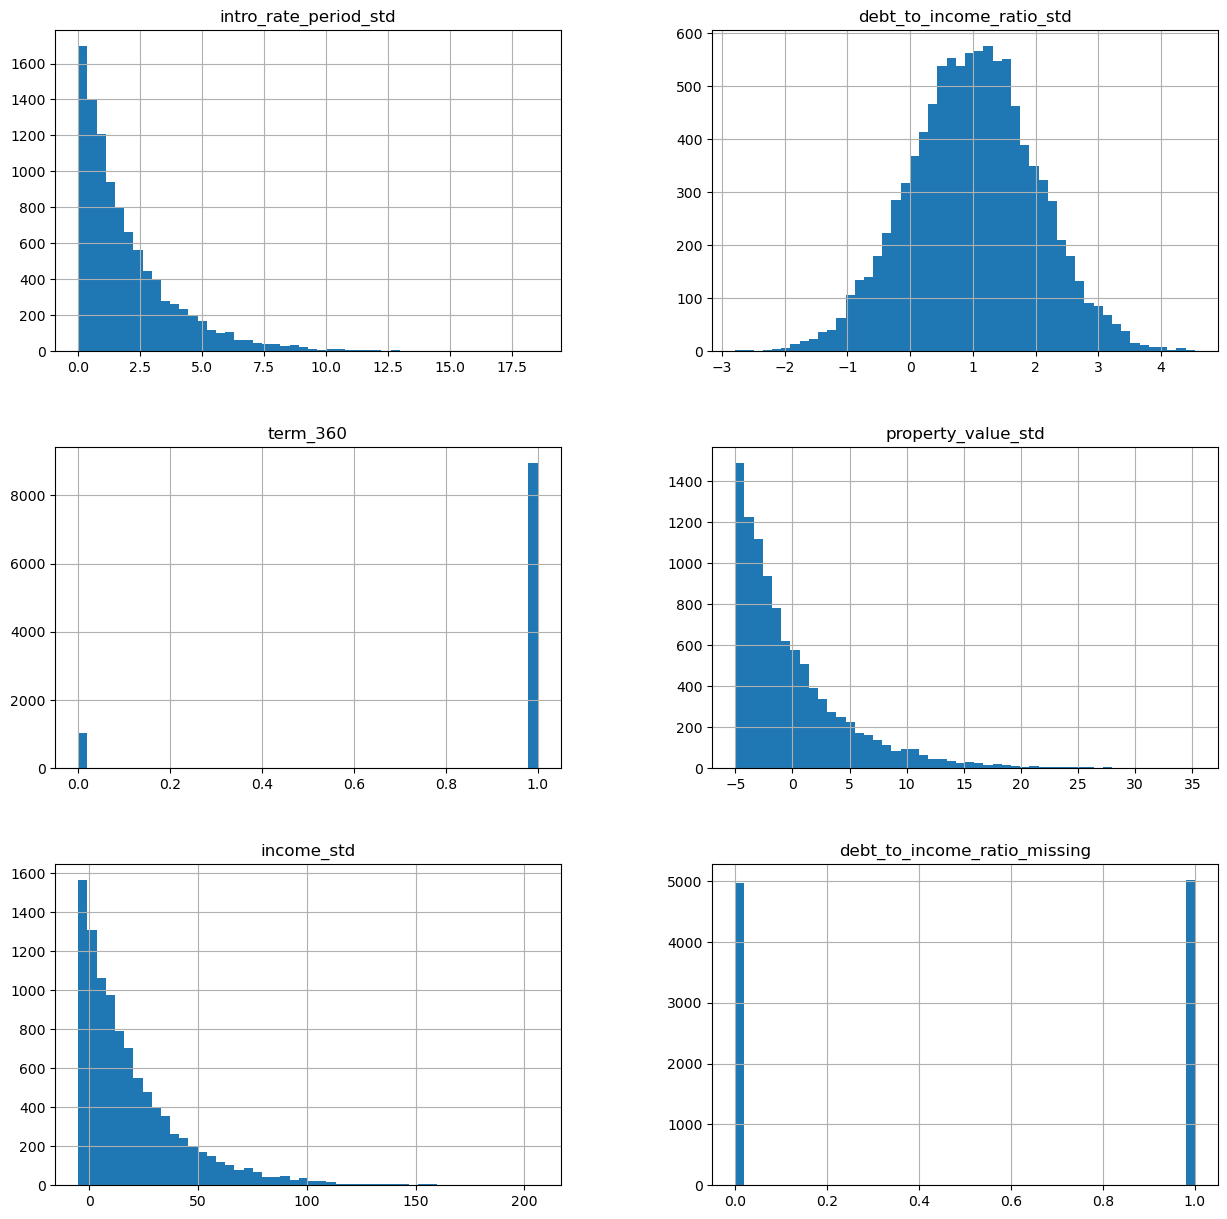

In [42]:
_ = random_frame[rem_features].hist(bins=50, figsize=(15, 15))

#### First Call to Blackbox Model for Predictions on Random Data

In [44]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_features])[:, 1], columns=['phat'])
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,term_360,debt_to_income_ratio_missing,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
0,0,1,0.047460,1.424353,20.226335,1.124646,0.581010
1,1,0,7.954180,22.240149,7.874433,1.123252,0.000008
2,1,0,3.762783,-2.492924,30.673523,2.683992,0.010008
3,1,1,0.100142,1.456200,-1.889726,-0.851652,0.862849
4,1,1,0.055818,-4.769201,17.451436,0.344748,0.124195


#### Extract a Stolen Decision Tree Model

In [46]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt',
                      SEED,
                      'Stolen Model')

#Convert h2o MOJO (stolen_dt.zip) into GraphViz file (stolen_dt.png)
!java -cp "/Users/moria/anaconda3/Lib/site-packages/h2o/backend/bin/h2o.jar" hex.genmodel.tools.PrintMojo --tree 0 -i "stolen_dt.zip" -o stolen_dt.gv --title "Stolen Model"

#Convert Graphviz file into png
!"C:/Program Files/Graphviz/bin/dot.exe" -Tpng stolen_dt.gv -o stolen_dt.png

#Three new files should appear:
# - stolen_dt.zip
# - stolen_dt.gv
# - stolen_dt.png
%ls

Generated MOJO path:
 C:\Users\moria\Documents\Mirands\Resp ML\Assignment 1-2\stolen_dt.zip
 Volume in drive C has no label.
 Volume Serial Number is D2A2-4EB3

 Directory of C:\Users\moria\Documents\Mirands\Resp ML\Assignment 1-2

04/10/2025  06:26 PM    <DIR>          .
04/10/2025  06:26 PM    <DIR>          ..
04/09/2025  05:16 PM    <DIR>          .ipynb_checkpoints
04/07/2025  12:07 AM         1,213,728 group3_assingment2.ipynb
04/07/2025  01:09 AM         1,182,434 group3_assingment3_higherAUC.ipynb
04/10/2025  06:26 PM           291,855 group3_assingment4.ipynb
03/26/2025  06:28 PM           326,541 group3_EBM.ipynb
03/26/2025  06:28 PM           341,488 group3_MGBM.ipynb
03/26/2025  05:31 PM           423,136 group3_ph_best_ebm.csv
03/26/2025  02:09 PM           247,047 group3_ph_best_mgbm.csv
04/07/2025  01:05 AM           419,549 group3_ph_rem_ebm.csv
03/24/2025  12:12 PM         3,598,974 hmda_test_preprocessed.csv
03/24/2025  12:12 PM        29,559,626 hmda_train_preprocess

#### View Stolen Model

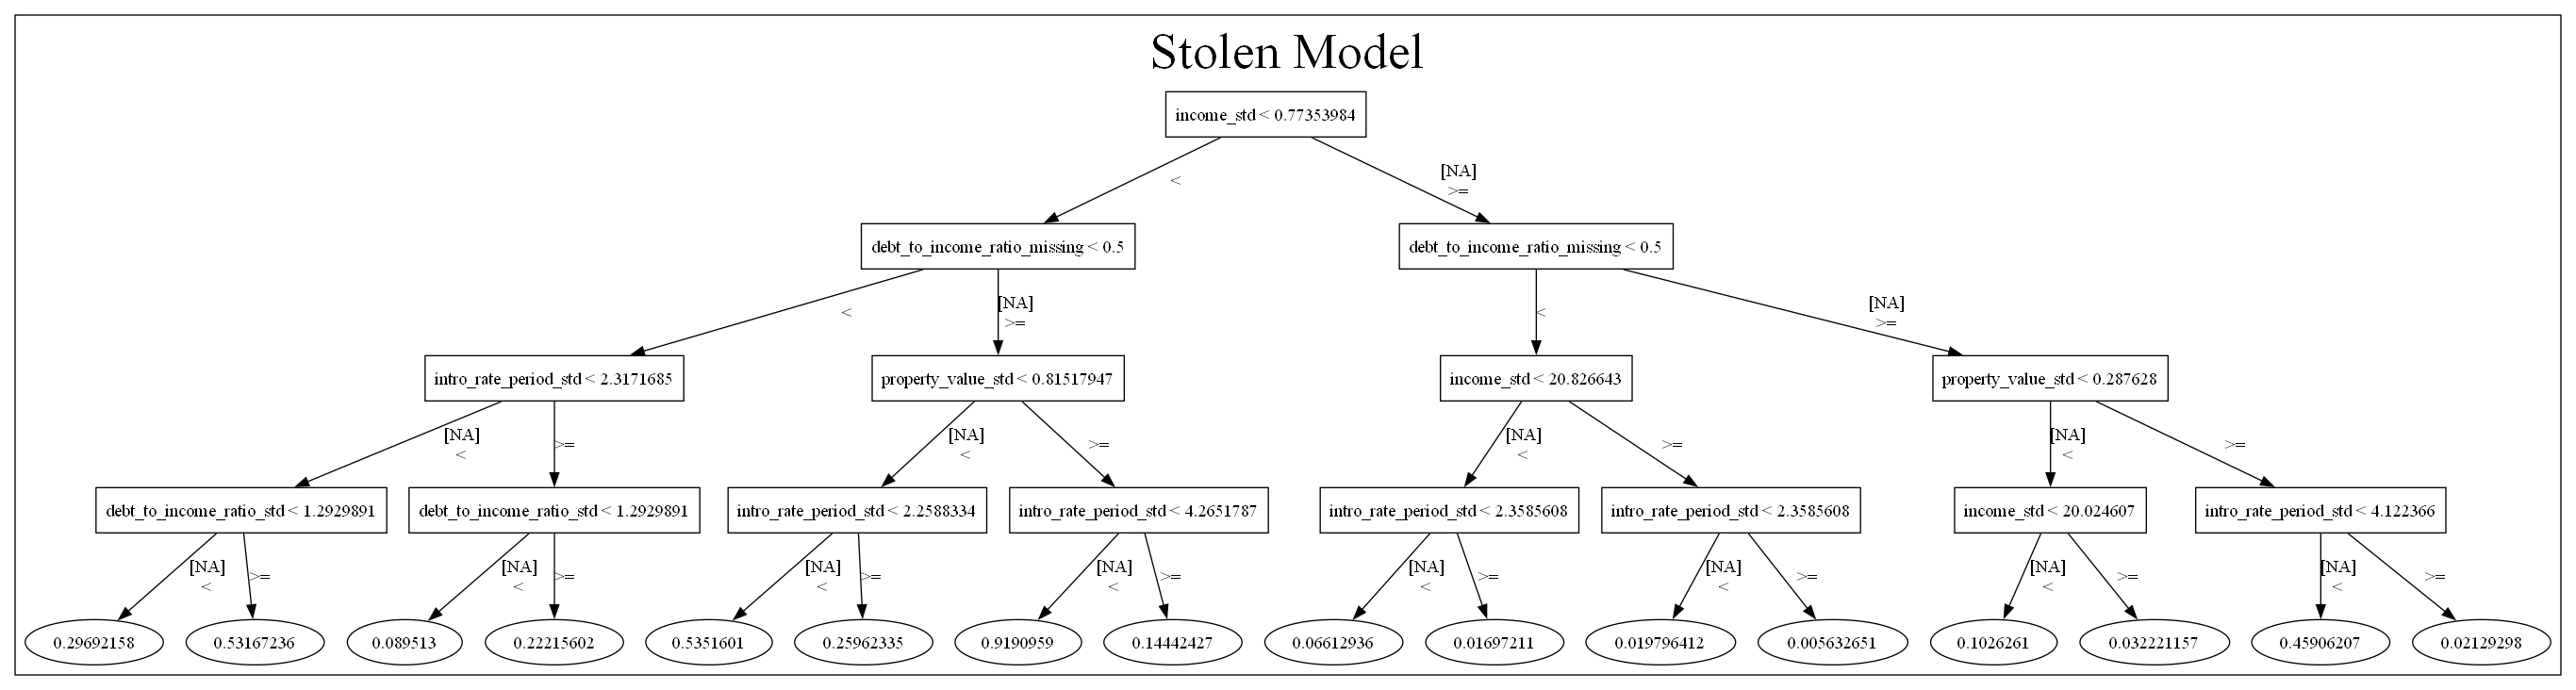

In [48]:
display(Image(('stolen_dt.png')))

#### Asessing Variable Importance of Stolen Model

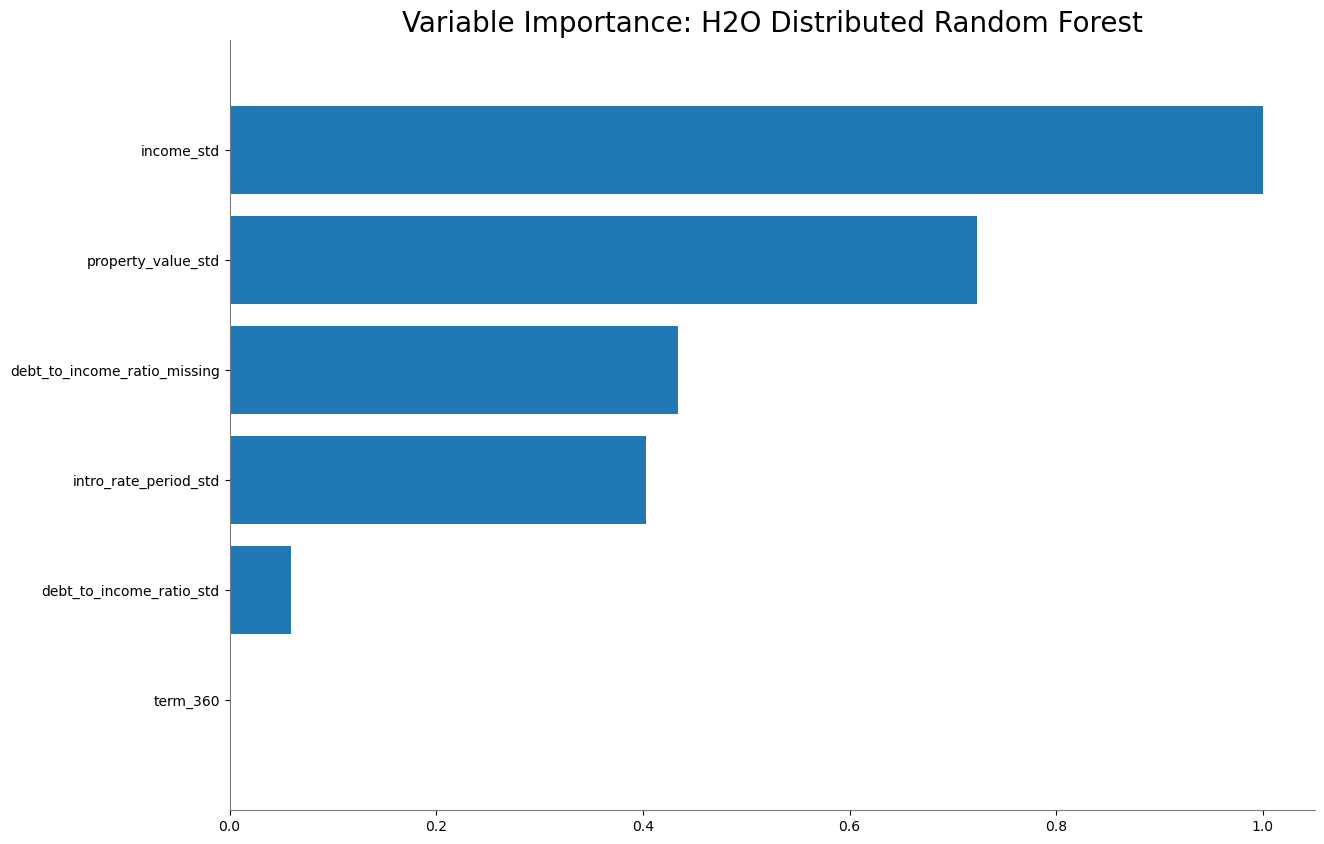

<Figure size 640x480 with 0 Axes>

In [50]:
stolen_dt.varimp_plot()

#### Assessing the Accuracy of Stolen Model

In [52]:
stolen_dt.cross_validation_metrics_summary() 

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
aic,nan,0.0,nan,nan,nan
loglikelihood,nan,0.0,nan,nan,nan
mae,0.0823066,0.0023441,0.0798609,0.0825252,0.0845337
mean_residual_deviance,0.0196650,0.0012224,0.0185810,0.0194239,0.0209899
mse,0.0196650,0.0012224,0.0185810,0.0194239,0.0209899
r2,0.7085934,0.0041424,0.7108564,0.7111114,0.7038125
residual_deviance,0.0196650,0.0012224,0.0185810,0.0194239,0.0209899
rmse,0.1401870,0.0043415,0.1363121,0.1393698,0.144879
rmsle,0.1020856,0.0028962,0.0992137,0.1020377,0.1050054


### **Use Stolen Model to Craft Adversarial Examples**

### Use Stolen Model to Find Seed Rows for Adversary Searches

In [55]:
#Updated per the splits indicated in the stolen decision tree
low_adversary_seed = random_frame.loc[(random_frame['income_std'] >= 0.77353984) &
                                      (random_frame['debt_to_income_ratio_missing'] < 0.5) &
                                      (random_frame['income_std'] >= 20.826643) &
                                      (random_frame['intro_rate_period_std'] >= 2.3585608)].mean() # note this traces the stolen tree to the lowest prediction - does it trace your tree?

print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['income_std'] < 0.77353984) &
                                       (random_frame['debt_to_income_ratio_missing'] >= 0.5) &
                                       (random_frame['property_value_std']>= 0.81517947) & 
                                       (random_frame['intro_rate_period_std'] < 4.2651787)].mean() # note this traces the stolen tree to the highest prediction - does it trace your tree?

print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
term_360                         0.893058
debt_to_income_ratio_missing     0.000000
intro_rate_period_std            4.359748
property_value_std               0.084979
income_std                      45.537987
debt_to_income_ratio_std         1.044871
dtype: float64

High adversarial example search seed row:
term_360                        0.887324
debt_to_income_ratio_missing    1.000000
intro_rate_period_std           1.540271
property_value_std              5.995708
income_std                     -2.120004
debt_to_income_ratio_std        1.023657
dtype: float64


### Perturb Seed Row to Find Low Scoring Adversarial Examples

In [58]:
#Init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

#Quantiles over which to search
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5]
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

idx = 0

#Generate potential adversarial examples across four important features
#Using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(high_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                for d in list(random_frame['term_360'].quantile(low_quantiles)):
                    low_adversary_seed_frame = pd.DataFrame(np.reshape(low_adversary_seed.values, (1, 6)), columns=list(schema_dict.keys()), index=[idx])
                    low_adversary_seed_frame['property_value_std'] = a
                    low_adversary_seed_frame['intro_rate_period_std'] = b
                    low_adversary_seed_frame['debt_to_income_ratio_std'] = c
                    low_adversary_seed_frame['term_360'] = d
                    low_adversary_frame = pd.concat([low_adversary_frame, low_adversary_seed_frame], axis=0)
                    idx += 1

#View potential low scoring adversarial examples
low_adversary_frame.head()

C:\Users\moria\AppData\Local\Temp\ipykernel_18804\3335921700.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  low_adversary_frame = pd.concat([low_adversary_frame, low_adversary_seed_frame], axis=0)


,term_360,debt_to_income_ratio_missing,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0.0,0.0,9.085445,18.137701,45.537987,-1.340151
1,0.0,0.0,9.085445,18.137701,45.537987,-1.340151
2,0.0,0.0,9.085445,18.137701,45.537987,-1.340151
3,1.0,0.0,9.085445,18.137701,45.537987,-1.340151
4,1.0,0.0,9.085445,18.137701,45.537987,-1.340151


### Perturb Seed Row to Find High Scoring Adversarial Examples

In [60]:
#Init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

idx = 0

#Generate potential adversarial examples across four important features
#Using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(low_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                for d in list(random_frame['term_360'].quantile(high_quantiles)):
                    high_adversary_seed_frame = pd.DataFrame(np.reshape(high_adversary_seed.values, (1, 6)), columns=list(schema_dict.keys()), index=[idx])
                    high_adversary_seed['property_value_std'] = a
                    high_adversary_seed['intro_rate_period_std'] = b
                    high_adversary_seed['debt_to_income_ratio_std'] = c
                    high_adversary_seed['term_360'] = d
                    high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)
                    idx += 1

#View potential high scoring adversarial examples
high_adversary_frame.head()

C:\Users\moria\AppData\Local\Temp\ipykernel_18804\3392706686.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)


,term_360,debt_to_income_ratio_missing,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,1.0,1.0,0.022874,-4.947597,-2.120004,3.341645
1,1.0,1.0,0.022874,-4.947597,-2.120004,3.341645
2,1.0,1.0,0.022874,-4.947597,-2.120004,3.341645
3,1.0,1.0,0.022874,-4.947597,-2.120004,3.341645
4,1.0,1.0,0.022874,-4.947597,-2.120004,3.341645


### Second Call to Blackbox API to Test Adversarial Examples

In [65]:
#Combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

#Score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_features])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,term_360,debt_to_income_ratio_missing,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
11,0.0,0.0,9.085445,18.137701,45.537987,-0.293709,7.411800e-08
12,0.0,0.0,9.085445,18.137701,45.537987,-0.293709,7.411800e-08
10,0.0,0.0,9.085445,18.137701,45.537987,-0.293709,7.411800e-08
7,0.0,0.0,9.085445,18.137701,45.537987,-0.693286,7.411800e-08
5,0.0,0.0,9.085445,18.137701,45.537987,-0.693286,7.411800e-08
...,...,...,...,...,...,...,...
629,1.0,1.0,0.022874,-4.947597,-2.120004,3.341645,9.054546e-01
879,1.0,1.0,0.022874,-4.493164,-2.120004,3.341645,9.054546e-01
878,1.0,1.0,0.022874,-4.493164,-2.120004,3.341645,9.054546e-01
1126,1.0,1.0,0.022874,-1.548983,-2.120004,3.341645,9.054546e-01


### End Timer

In [67]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 468.13 s.


### Shutdown H2O

In [70]:
#Be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)?  Y


H2O session _sid_82b4 closed.
